In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_original = pd.read_csv('../input/spaceship-titanic/train.csv')
test_original = pd.read_csv('../input/spaceship-titanic/test.csv')
sample_original = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

In [4]:
train = train_original.copy()
test = test_original.copy()
sample = sample_original.copy()

In [5]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
sample.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


# Examine Data from here

## Missing Data

In [7]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

There're many missing data.
I'll decide how to implement this later.

## HomePlanets and Destinations

In [9]:
print(train['HomePlanet'].value_counts())
print(train['Destination'].value_counts())
print()
print(test['HomePlanet'].value_counts())
print(test['Destination'].value_counts())

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

Earth     2263
Europa    1002
Mars       925
Name: HomePlanet, dtype: int64
TRAPPIST-1e      2956
55 Cancri e       841
PSO J318.5-22     388
Name: Destination, dtype: int64


<AxesSubplot:xlabel='HomePlanet,Destination'>

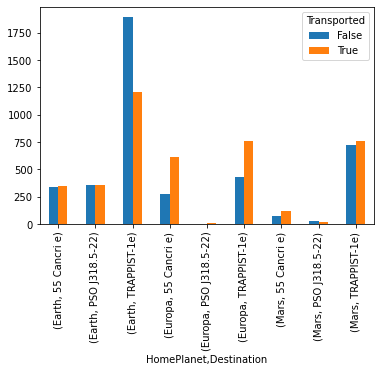

In [10]:
train.groupby(['HomePlanet', 'Destination', 'Transported']).size().unstack().plot(kind='bar')

In [11]:
train.groupby(['HomePlanet', 'Destination', 'Transported']).size().unstack()

Transported               False  True 
HomePlanet Destination                
Earth      55 Cancri e      342    348
           PSO J318.5-22    357    355
           TRAPPIST-1e     1894   1207
Europa     55 Cancri e      275    611
           PSO J318.5-22      5     14
           TRAPPIST-1e      434    755
Mars       55 Cancri e       75    118
           PSO J318.5-22     27     22
           TRAPPIST-1e      720    755

It seems we'd better use 'Homeplanet'+ 'Earth -> TRAPPIST' flag, and drop 'Destination'.

## Spends on luxries

In [12]:
spends = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

<ipython-input-13-f199577bb30f>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


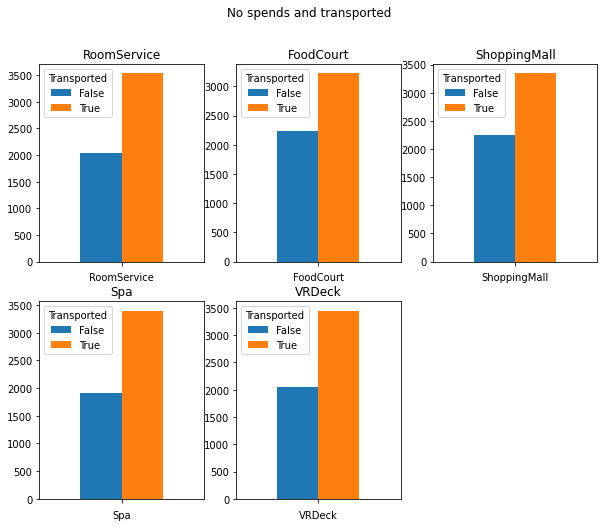

In [13]:
fig = plt.figure(figsize=(10, 8))
for i, sp in enumerate(spends, start=1):
    ax = fig.add_subplot(2, 3, i)
    tmp = train[train[sp] < 1]
    tmp.groupby([sp, 'Transported']).size().unstack().plot(kind='bar', ax=ax)
    ax.set_title(sp)
    ax.set_xticklabels("")
fig.suptitle('No spends and transported')
fig.show()

<ipython-input-14-434cd2e611a9>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


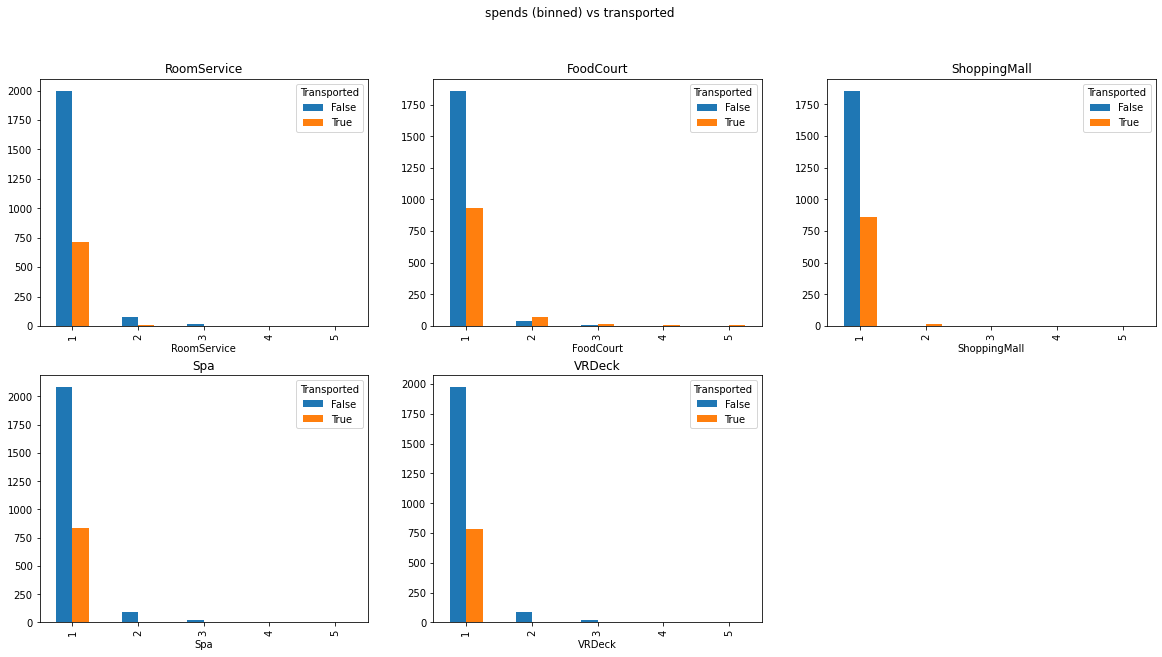

In [14]:
fig = plt.figure(figsize=(20, 10))
for i, sp in enumerate(spends, start=1):
    ax = fig.add_subplot(2, 3, i)
    tmp = train[train[sp]>1]  # spend some money on it
    tmp.groupby([pd.cut(tmp[sp], bins=5), 'Transported']).size().unstack().plot(kind='bar', ax=ax)
    ax.set_title(sp)
    ax.set_xticklabels([1, 2, 3, 4, 5])
fig.suptitle('spends (binned) vs transported')
fig.show()

As a whole, wheather the passenger spent some money on luxuries matters and how much the passenger spent doesn't matter.

But it seems a bit contradicted tendency in Food Court data.

In [15]:
train['whole_spends'] = train[spends].fillna(0).sum(axis=1)
train['fc_percent'] = train['FoodCourt'].fillna(0) / train['whole_spends']
train['fc_percent'] = train['fc_percent'].fillna(0) # concidering div by 0

<AxesSubplot:xlabel='fc_percent'>

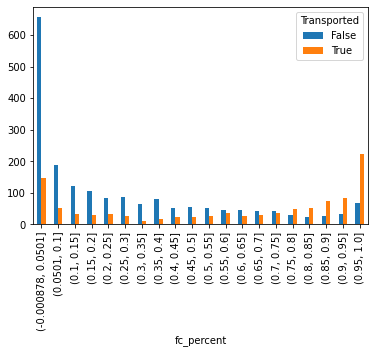

In [16]:
tmp = train[train['FoodCourt']>1]
tmp.groupby([pd.cut(tmp['fc_percent'], 20), 'Transported']).size().unstack().plot(kind='bar')

there's a clear correlation between "transported" and FoodCourt spend percentage.

From insight shown above, we gonna make new features 'no_spends' and 'fc_percent', and drop individual data of spends.

## VIP

<AxesSubplot:xlabel='VIP'>

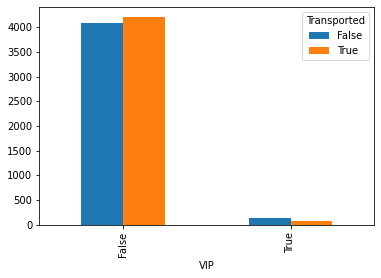

In [17]:
train.groupby(['VIP', 'Transported']).size().unstack().plot(kind='bar')

Not a big difference, but it would be useful anyway.

## Age

<AxesSubplot:xlabel='Age'>

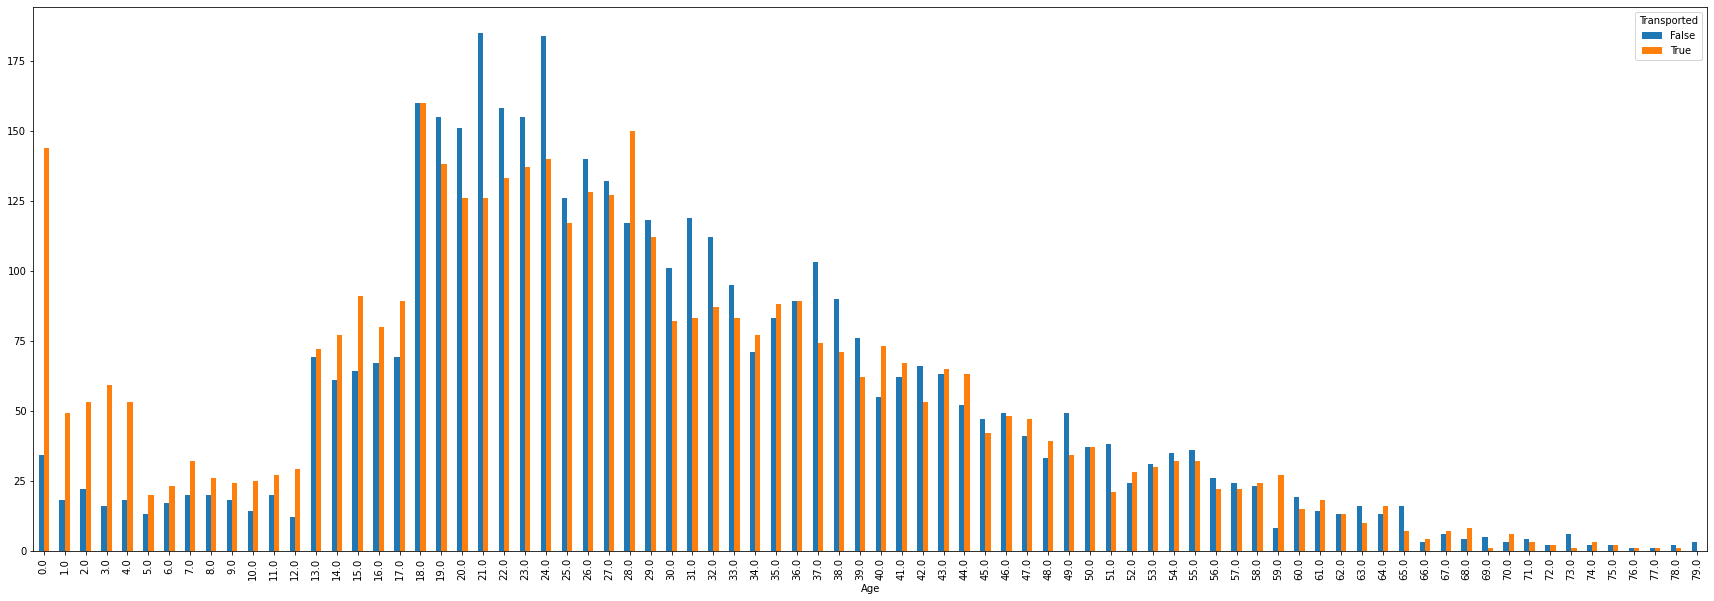

In [18]:
train.groupby(['Age', 'Transported']).size().unstack().plot(kind='bar', figsize=(30, 10))

There's a clear difference (thresholds) between age of 4-5 and 17-18.

So it would be better making new feature 'age_cat' as below and drop 'Age'.
- age_cat 0: age 0-4
- age_cat 1: age 5-17
- age_cat 2: age 18-

## CryoSleep

<AxesSubplot:xlabel='CryoSleep'>

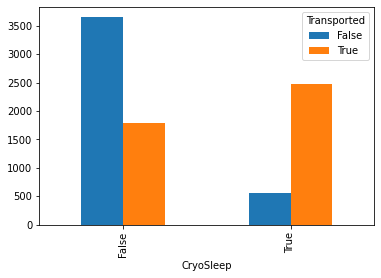

In [19]:
train.groupby(['CryoSleep', 'Transported']).size().unstack().plot(kind='bar')

I'll use it as it is.

## Cabin

In [20]:
cabin_split = train['Cabin'].str.split('/', expand=True)
cabin_split.columns = ['cabin_group', 'cabin_num', 'cabin_side']
train = pd.concat([train, cabin_split], axis=1)

<AxesSubplot:xlabel='cabin_group'>

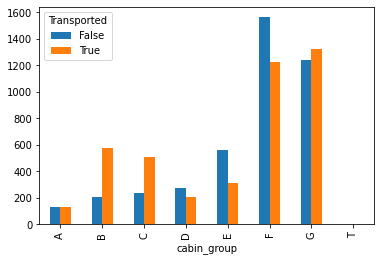

In [21]:
train.groupby(['cabin_group', 'Transported']).size().unstack().plot(kind='bar')

<AxesSubplot:xlabel='cabin_side'>

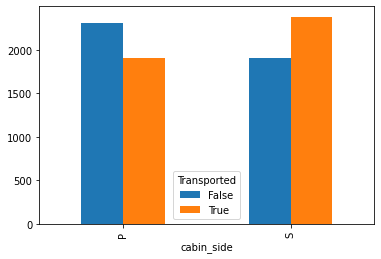

In [22]:
train.groupby(['cabin_side', 'Transported']).size().unstack().plot(kind='bar')

In [23]:
train['cabin_num'].unique()

array(['0', '1', '2', ..., '1892', '1893', '1894'], dtype=object)

I gonna drop 'cabin_num' but use 'cabin_group' and 'cabin_side'.

## PassengerId

You can get size of passengers' groups from PassengerId.

In [24]:
pid_split = train['PassengerId'].str.split('_', expand=True)
pid_split.columns = ['id_group', 'id_branch']
train = pd.concat([train, pid_split], axis=1)

In [25]:
id_to_size = pid_split.groupby('id_group').size()
train['group_size'] = train['id_group'].map(id_to_size)

<AxesSubplot:xlabel='group_size'>

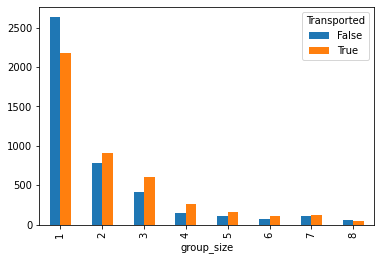

In [26]:
train.groupby(['group_size', 'Transported']).size().unstack().plot(kind='bar')

I gonna try to use is as it is.

## Implementation + Data Engineering

In [27]:
# PassengerId

def process_passenger_id(df):
    split_id = df['PassengerId'].str.split('_', expand=True)
    split_id.columns = ['pid_group', 'pid_branch']
    df['group_size'] = split_id['pid_group'].map(split_id.groupby('pid_group').size())
    return df

In [28]:
# HomePlanet -> Destination
print(train_original['HomePlanet'].unique())
print(test_original['HomePlanet'].unique())
print(train_original['Destination'].unique())
print(test_original['Destination'].unique())


['Europa' 'Earth' 'Mars' nan]
['Earth' 'Europa' 'Mars' nan]
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
['TRAPPIST-1e' '55 Cancri e' 'PSO J318.5-22' nan]


In [29]:
from sklearn.preprocessing import OneHotEncoder
def process_route(df):
    df['HomePlanet'].fillna('NA', inplace=True)
    df['Destination'].fillna('NA', inplace=True)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoded = pd.DataFrame(ohe.fit_transform(df[['HomePlanet']]))
    col = ['route_' + str(i) for i in range(len(encoded.columns))]
    encoded.columns = col
    df = pd.concat([df, encoded], axis=1)
    df['earth_trappist'] = 0
    df.loc[(df['HomePlanet']=='Earth') & (df['Destination']=='TRAPPIST-1e'), 'earth_trappist'] = 1
    return df
    

In [30]:
# Cabin
print(train_original['Cabin'].str.split('/', expand=True)[0].unique())
print(test_original['Cabin'].str.split('/', expand=True)[0].unique())

['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
['G' 'F' 'C' 'B' 'D' 'E' nan 'A' 'T']


In [31]:
def process_cabin(df):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    df['Cabin'].fillna('X/X/X', inplace=True)
    cabin_split = df['Cabin'].str.split('/', expand=True)
    cabin_split.columns = ['cabin_group', 'cabin_num', 'cabin_side']
    encoded = pd.DataFrame(ohe.fit_transform(cabin_split[['cabin_group', 'cabin_side']]))
    col = ['cabin_' + str(i) for i in range(len(encoded.columns))]
    encoded.columns = col
    return pd.concat([df, encoded], axis=1)

In [32]:
# Age
train_original['Age'].describe()

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

they must be around 30-year-old

In [33]:
def process_age(df):
    df['Age'].fillna(30, inplace=True)
    df['cat_age'] = 0
    df.loc[df['Age'] > 4, 'cat_age'] = 1
    df.loc[df['Age'] > 17, 'cat_age'] = 2
    return df
    

In [34]:
# luxuries spend
spends = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [35]:
def process_spends(df):
    for sp in spends:
        df[sp].fillna(0, inplace=True)
    df['whole_spends'] = df[spends].sum(axis=1)
    df['no_spends'] = 0
    df.loc[df['whole_spends']<1, 'no_spends'] = 1
    df['foodcourt_percentage'] = df['FoodCourt'] / df['whole_spends']
    df[df['foodcourt_percentage'].isnull()] = 1
    return df

In [36]:
X = train_original.copy()
y = X.pop('Transported')

In [37]:
# CryoSleep
def process_others(df):
    df['CryoSleep'] = df['CryoSleep'].astype('float')
    df['VIP'] = df['VIP'].astype('float')
    df.loc[df['CryoSleep'].isnull(), 'CryoSleep'] = 0.5
    df.loc[df['VIP'].isnull(), 'VIP'] = 0.5
    return df

In [38]:
def preprocess(df):
    df = process_passenger_id(df)
    df = process_route(df)
    df = process_cabin(df)
    df = process_age(df)
    df = process_spends(df)
    df = process_others(df)
    df.drop(['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Age', 'Name'], axis=1, inplace=True)
    df.drop(spends, axis=1, inplace=True)
    return df

In [39]:
X = train_original.copy()
y = X.pop('Transported')
test_X = test_original.copy()

In [40]:
X = preprocess(X)
test_X = preprocess(test)

In [41]:
X.head()

,CryoSleep,VIP,group_size,route_0,route_1,route_2,route_3,earth_trappist,cabin_0,cabin_1,...,cabin_6,cabin_7,cabin_8,cabin_9,cabin_10,cabin_11,cat_age,whole_spends,no_spends,foodcourt_percentage
0,1.0,1.0,1,1.0,1.0,1.0,1.0,1,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1,1.000000
1,0.0,0.0,1,1.0,0.0,0.0,0.0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2,736.0,0,0.012228
2,0.0,1.0,2,0.0,1.0,0.0,0.0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2,10383.0,0,0.344409
3,0.0,0.0,2,0.0,1.0,0.0,0.0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2,5176.0,0,0.247875
4,0.0,0.0,1,1.0,0.0,0.0,0.0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,1091.0,0,0.064161


In [42]:
test_X.head()

,CryoSleep,VIP,group_size,route_0,route_1,route_2,route_3,earth_trappist,cabin_0,cabin_1,...,cabin_6,cabin_7,cabin_8,cabin_9,cabin_10,cabin_11,cat_age,whole_spends,no_spends,foodcourt_percentage
0,1.0,1.0,1,1.0,1.0,1.0,1.0,1,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1,1.000000
1,0.0,0.0,1,1.0,0.0,0.0,0.0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2,2832.0,0,0.003178
2,1.0,1.0,1,1.0,1.0,1.0,1.0,1,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1,1.000000
3,0.0,0.0,1,0.0,1.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2,7418.0,0,0.896738
4,0.0,0.0,1,1.0,0.0,0.0,0.0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2,645.0,0,0.000000


In [44]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


In [91]:
from itertools import product
def grid_search_best_params(model_class, param_lists, X, y, kf, eval_metric=None, early_stopping_rounds=42, verbose=None):
    param_names = list(param_lists.keys())
    params = list(param_lists.values())
    results = []
    for param_combination in product(*params):
        param_try = {k:v for k, v in zip(param_names, param_combination)}
        print(param_try)
        model = model_class(**param_try)

        score, valid_preds = get_score_with_cv(model, X, y, kf, eval_metric, early_stopping_rounds, verbose)

        print(str(model_class), score, param_try)
        results.append([score, param_try, valid_preds])
    return results

def get_score_with_cv(model, X, y, kf, eval_metric=None, early_stopping_rounds=42, verbose=0):
    '''
    与えられた model, データ, KFold を用いて学習し、
    スコアとスタッキング用の valid 予測値を返す
    '''
    kf_scores = []
    valid_preds = [0] * len(y)
    for train, valid in kf.split(X, y):

        train_X = X.iloc[train]
        train_y = y.iloc[train]
        valid_X = X.iloc[valid]
        valid_y = y.iloc[valid]

        model.fit(
            train_X, train_y,
            early_stopping_rounds=early_stopping_rounds,
            eval_set=[[valid_X, valid_y]],
            eval_metric=eval_metric,
            verbose=verbose
        )
        kf_scores.append(model.best_score)

        valid_pred = model.predict(valid_X)
        for i, value in zip(valid, valid_pred):
            valid_preds[i] = value

    score = sum(kf_scores) / len(kf_scores)
    return [score, valid_preds]



In [119]:
from xgboost import XGBClassifier, XGBRegressor
xgb_params = {
    "n_estimators": [10000],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
}

results = grid_search_best_params(
    XGBRegressor, xgb_params, X, y, kf
)

{'n_estimators': 10000}
<class 'xgboost.sklearn.XGBRegressor'> 0.4070392 {'n_estimators': 10000}


In [120]:
min(results)

[0.4070392,
 {'n_estimators': 10000},
 [0.784445,
  0.24641544,
  0.0038352027,
  0.10025537,
  0.17705576,
  0.3918014,
  0.85280997,
  0.7890937,
  0.5510021,
  0.7825044,
  0.7890937,
  0.9825145,
  0.2503705,
  0.25300545,
  0.44825694,
  0.2326697,
  0.18560365,
  0.15139166,
  0.7877175,
  0.78660595,
  0.30112964,
  0.78660595,
  0.7890937,
  0.7877175,
  0.784445,
  0.7890937,
  0.78660595,
  0.24293117,
  0.784445,
  0.3544223,
  0.758269,
  0.24774165,
  0.21323605,
  0.18282552,
  0.78660595,
  0.22390075,
  0.78660595,
  0.22478618,
  0.4199246,
  0.12993757,
  0.7890937,
  0.78660595,
  0.18620996,
  0.78660595,
  0.784445,
  0.78660595,
  0.112710506,
  0.784445,
  0.19837612,
  0.24706832,
  0.08666344,
  0.17744602,
  0.784445,
  0.784445,
  0.024507843,
  0.78660595,
  0.2798872,
  0.6351877,
  0.784445,
  0.7877175,
  0.2202034,
  0.7890937,
  0.24907437,
  0.31671286,
  0.15847893,
  0.3297106,
  0.22012115,
  0.98035944,
  0.1800371,
  0.25833577,
  1.0070704,
  0.4

In [121]:
pred = min(results)[2]

In [122]:
pred_tf = [1 if v > 0.5 else 0 for v in pred]

from sklearn.metrics import accuracy_score
accuracy_score(y, pred_tf)

0.7775221442539975